In [1]:
import os
import numpy as np
import pandas as pd
# import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

ModuleNotFoundError: No module named 'numpy'

In [2]:
# Dataset: https://www.kaggle.com/datasets/kritikseth/fruit-and-vegetable-image-recognition

base_dir = './'
img_size = (224, 224)
batch_size = 32

In [3]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [4]:
def num_of_classes(folder_dir, folder_name) :
    classes = [class_name for class_name in os.listdir(train_dir)]
    print(f'number of classes in {folder_name} folder : {len(classes)}')

In [5]:
num_of_classes(train_dir, 'train')
num_of_classes(validation_dir, 'validation')
num_of_classes(test_dir, 'test')

number of classes in train folder : 36
number of classes in validation folder : 36
number of classes in test folder : 36


In [6]:
classes = [class_name for class_name in os.listdir(train_dir)]
def create_df(folder_path) :
    all_images = []    
    for class_name in classes :
        class_path = os.path.join(folder_path, class_name)
        all_images.extend([(os.path.join(class_path, file_name), class_name) for file_name in os.listdir(class_path)])
    df = pd.DataFrame(all_images, columns=['file_path', 'label'])
    return df

In [7]:
train_df = create_df(train_dir)
validation_df = create_df(validation_dir)
test_df = create_df(test_dir)

In [8]:
# Train generator

train_datagen = ImageDataGenerator(
    rescale=1./255,                 # Scaled images in range 0 to 1
    rotation_range=20,              # Rorate images by factor 20 degree
    width_shift_range=0.2,          # Shift images horizontally by up to 20% of their width
    height_shift_range=0.2,         # Shift images vertically by up to 20% of their width
    zoom_range=0.1,                 # Zoom in and out images by 10%
    horizontal_flip=True,           # Allow horizontal flipping
    shear_range=0.1,                # shear images by 10% their size
    fill_mode='nearest',            # fill unlocated pixels by nearest pixel
    )

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,             # Target data
    x_col='file_path',              # X column
    y_col='label',                  # y column
    target_size=(224, 224),         # Resize images  to
    color_mode='rgb',               # Color mode
    class_mode='categorical',       # type of model
    batch_size=32,                  
    shuffle=True,
    seed=42,
    
)

Found 3115 validated image filenames belonging to 36 classes.


In [9]:
# validation generator

validation_datagen = ImageDataGenerator(rescale=1./255,)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=validation_df,
    x_col='file_path',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    seed=42,
    shuffle=False
)

Found 351 validated image filenames belonging to 36 classes.


In [10]:
# Test generator

test_datagen = ImageDataGenerator(rescale=1./255,)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='file_path',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    seed=42,
    shuffle=False
)

Found 359 validated image filenames belonging to 36 classes.


In [11]:
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model.trainable = False  # Congela el modelo base

I0000 00:00:1731961726.184292  110522 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10061 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:04:00.0, compute capability: 6.1


In [12]:
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(36, activation='softmax'))

In [13]:
from tensorflow.keras import optimizers

In [14]:
model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
             loss='categorical_crossentropy', 
             metrics=['accuracy'])

In [15]:
# Model CheckPoint
checkpoint_cb = ModelCheckpoint('MyModel.keras', save_best_only=True) 

# Early Stoping
earlystop_cb = EarlyStopping(patience=10, restore_best_weights=True)

# ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [16]:
# Entrenar el modelo
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[checkpoint_cb, earlystop_cb, reduce_lr]
)

/home/labmirp/Santiago/env/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1731961734.624707  110646 service.cc:148] XLA service 0x7d5b98041910 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731961734.624731  110646 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2024-11-18 15:28:54.734320: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1731961735.443520  110646 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-11-18 15:28:57.342518: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version 12.5.82. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


 1/98 ━━━━━━━━━━━━━━━━━━━━ 14:22 9s/step - accuracy: 0.0000e+00 - loss: 4.3096

I0000 00:00:1731961738.645152  110646 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 7/98 ━━━━━━━━━━━━━━━━━━━━ 2:03 1s/step - accuracy: 0.0669 - loss: 12.0811

/home/labmirp/Santiago/env/lib/python3.11/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 949ms/step - accuracy: 0.3008 - loss: 6.5223

/home/labmirp/Santiago/env/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


98/98 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/step - accuracy: 0.3022 - loss: 6.4918 - val_accuracy: 0.7835 - val_loss: 0.6977 - learning_rate: 0.0010
Epoch 2/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.6700 - loss: 1.2217 - val_accuracy: 0.8689 - val_loss: 0.4494 - learning_rate: 0.0010
Epoch 3/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.7346 - loss: 0.9096 - val_accuracy: 0.9117 - val_loss: 0.3228 - learning_rate: 0.0010
Epoch 4/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 96s 977ms/step - accuracy: 0.7664 - loss: 0.7922 - val_accuracy: 0.9088 - val_loss: 0.2545 - learning_rate: 0.0010
Epoch 5/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 96s 983ms/step - accuracy: 0.8175 - loss: 0.6086 - val_accuracy: 0.8746 - val_loss: 0.3593 - learning_rate: 0.0010
Epoch 6/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 97s 995ms/step - accuracy: 0.8172 - loss: 0.5690 - val_accuracy: 0.9259 - val_loss: 0.2378 - learning_rate: 0.0010
Epoch 7/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 95s 965ms/step - accuracy: 0.8186 - loss: 0.5620 - val_accurac

In [19]:
loss, accuracy = model.evaluate(test_generator)
print(f"Pérdida en el conjunto de prueba: {loss}")
print(f"Precisión en el conjunto de prueba: {accuracy}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.9660 - loss: 0.1339 
Pérdida en el conjunto de prueba: 0.14255769550800323
Precisión en el conjunto de prueba: 0.9582172632217407


In [46]:
from sklearn.metrics import classification_report

In [47]:
print(classification_report(test_generator.classes, np.argmax(model.predict(test_generator), axis=-1)))

12/12 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step 
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       1.00      0.78      0.88         9
           2       1.00      1.00      1.00        10
           3       0.83      1.00      0.91        10
           4       1.00      1.00      1.00        10
           5       1.00      0.80      0.89        10
           6       1.00      0.90      0.95        10
           7       1.00      1.00      1.00        10
           8       0.83      1.00      0.91        10
           9       0.78      0.70      0.74        10
          10       1.00      1.00      1.00        10
          11       1.00      1.00      1.00        10
          12       1.00      1.00      1.00        10
          13       1.00      1.00      1.00        10
          14       1.00      1.00      1.00        10
          15       1.00      0.90      0.95        10
          16       1.00      1.00      1.

In [26]:
# Convert resutl of training to a DataFrame
result_df = pd.DataFrame(history.history)
result_df.tail()

,accuracy,loss,val_accuracy,val_loss,learning_rate
23,0.968218,0.094494,0.957265,0.157320,0.000125
24,0.971108,0.082539,0.960114,0.162060,0.000063
25,0.975923,0.075148,0.960114,0.155451,0.000063
26,0.977528,0.067440,0.960114,0.151564,0.000063
27,0.973034,0.078084,0.962963,0.157414,0.000031


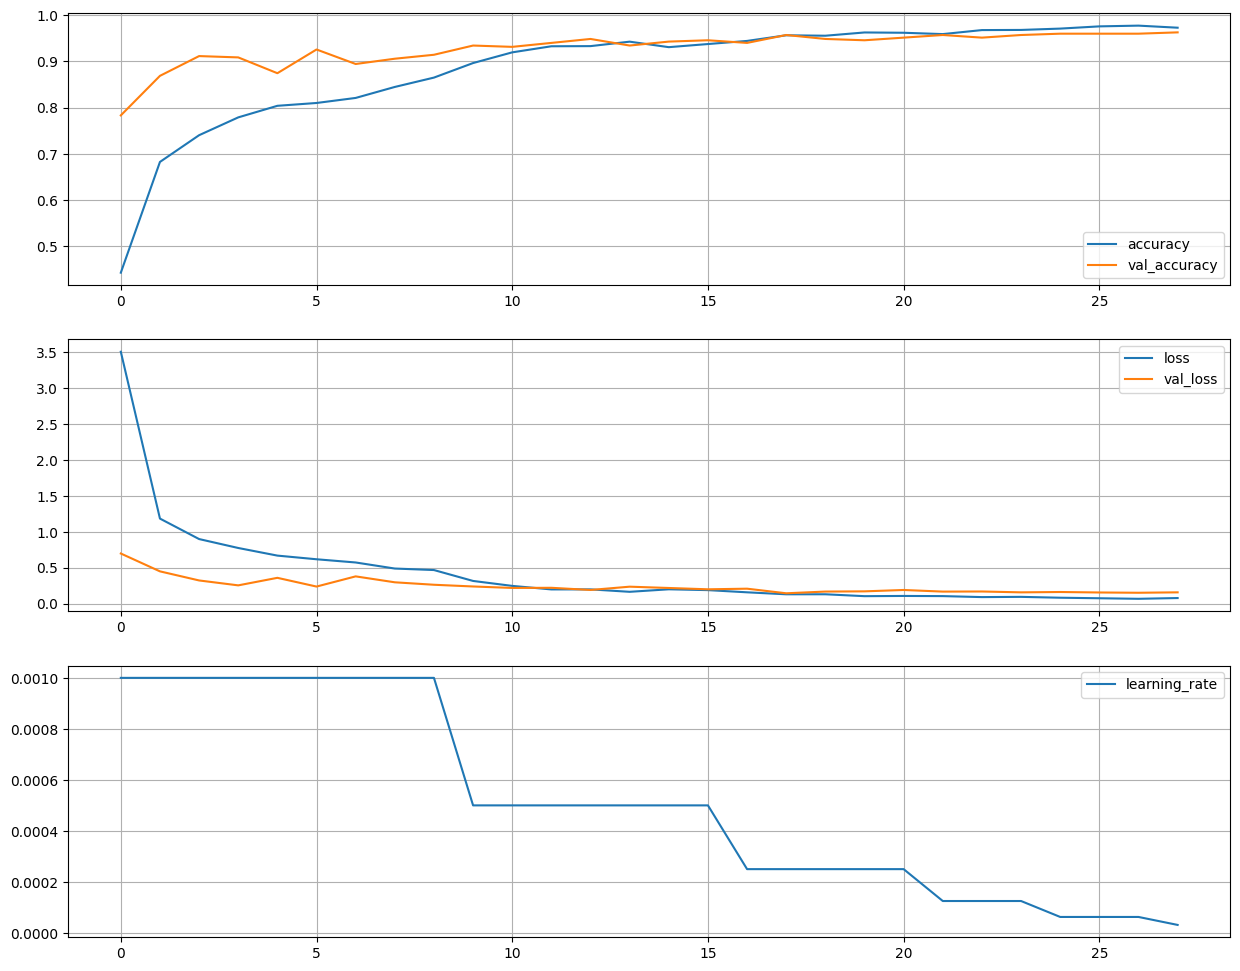

In [28]:
x = np.arange(len(result_df))
fig, ax = plt.subplots(3, 1, figsize=(15, 12))

ax[0].plot(x, result_df['accuracy'], label='accuracy')
ax[0].plot(x, result_df['val_accuracy'], label='val_accuracy')
ax[0].legend(loc='best')
ax[0].grid(True)

ax[1].plot(x, result_df['loss'], label='loss')
ax[1].plot(x, result_df['val_loss'], label='val_loss')
ax[1].legend(loc='best')
ax[1].grid(True)

ax[2].plot(x, result_df['learning_rate'], label='learning_rate')
ax[2].legend(loc='best')
ax[2].grid(True)

plt.show()

In [29]:
best_model = models.load_model('MyModel.keras')

In [32]:
# Evaluate the model on the test data
test_loss, test_accuracy = best_model.evaluate(test_generator)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 958ms/step - accuracy: 0.9660 - loss: 0.1339
Test Loss: 0.14255769550800323
Test Accuracy: 0.9582172632217407


In [43]:
import numpy as np
from PIL import Image

# Probar el modelo con una imagen
image_path = './05.jpg'
img = Image.open(image_path).convert("RGB")
img = img.resize((224, 224))
img_array = np.array(img, dtype=np.float32)
img_array = np.expand_dims(img_array, axis=0)  # Añadir dimensión para batch
img_array /= 255.0  # Normalizar entre 0 y 1

predictions = best_model.predict(img_array)

# Decodificar la predicción
class_labels = train_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}  # Invertir el diccionario
predicted_class_index = np.argmax(predictions[0])      # Índice de la clase con mayor probabilidad
predicted_class = class_labels[predicted_class_index]  # Nombre de la clase

print(f"La imagen pertenece a la clase: {predicted_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
La imagen pertenece a la clase: lemon


In [44]:
# Convertir el modelo a formato TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(best_model)
tflite_model = converter.convert()

# Guardar el modelo TFLite en un archivo
with open('MyModel.tflite', 'wb') as f:
    f.write(tflite_model)

print("El modelo se ha convertido y guardado como 'MyModel.tflite'")


INFO:tensorflow:Assets written to: /tmp/tmp7qgr0fmh/assets


INFO:tensorflow:Assets written to: /tmp/tmp7qgr0fmh/assets


Saved artifact at '/tmp/tmp7qgr0fmh'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 36), dtype=tf.float32, name=None)
Captures:
  137836172729744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137836172731088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137836172731280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137836172730896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137836172730320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137836172731664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137836172733008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137836172733200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137836172732816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137836172732048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137836172733

W0000 00:00:1732032399.875312  110522 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1732032399.875565  110522 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2024-11-19 11:06:39.879562: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp7qgr0fmh
2024-11-19 11:06:39.894939: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-11-19 11:06:39.894970: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmp7qgr0fmh
2024-11-19 11:06:40.050632: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-11-19 11:06:40.906961: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmp7qgr0fmh
2024-11-19 11:06:41.113177: I tensorflow/cc/saved_model/loader.cc:466] SavedModel load for tags { serve }; Status: success: OK. Took 1233821 microseconds.


El modelo se ha convertido y guardado como 'MyModel.tflite'
